<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/notebooks/Text_Classification_full_vs_machine_summarized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize 

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning/src")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 345 (delta 184), reused 55 (delta 17), pack-reused 0
Receiving objects: 100% (345/345), 8.29 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

## link to dataset summarized IMDB folder
# !gdown --id '1vopK4kYv2dsHtrMjc0loS0vfdlwhWbU1'

Mounted at /content/gdrive


In [3]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.2MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 59.5MB/s 
     |████████████████████████████████| 901kB 42.8MB/s 
     |████████████████████████████████| 839kB 7.4MB/s 
     |████████████████████████████████| 235kB 53.8MB/s 
     |████████████████████████████████| 122kB 57.2MB/s 
     |████████████████████████████████| 829kB 49.3MB/s 
     |████████████████████████████████| 276kB 51.4MB/s 
     |████████████████████████████████| 1.3MB 31.1MB/s 
     |████████████████████████████████| 143kB 58.8MB/s 
     |████████████████████████████████| 296kB 62.3MB/s 


In [4]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import json


import torch
from torchtext.datasets import IMDB
import torchtext.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import nn

import utils
import models



print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
GPU: Tesla T4
Memory: 15.84 Gb


# Display data
## Get the IMDB dataset and create a vocabulary from the train dataset
I use the IMDB test data as train

In [5]:
tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<sos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 82.5MB/s]


## Create text and labels pipelines

In [6]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x=='neg' else 1

## Print some random samples and the size of the dataset

In [7]:
train_iter = IMDB(split='train')
n_samples = len(train_iter)
random_list = torch.randint(0, n_samples - 1, (4, ))
labels = []
for i, (label, text) in enumerate(train_iter):
    labels.append(label)
    if i in random_list:
        print(f'Label: {label_pipeline(label)}')
        print(f'Text: {text}')
        print(f'Split: {tokenizer(text)}')
        print(f'Tokens: {text_pipeline(text)}\n')
print('Number of classes: {}'.format(len(set(labels))))
print('Number of samples: {}'.format(n_samples))

Label: 0
Text: Well.......in contrast to other comments previously written I have to say that the only good thing about this film is the fact that one guy in it looked a bit like Jason Donavon which reminded me of my youth. I have no idea how it won any awards, and although I'm sure a great deal of effort went into making it it was all fruitless as the final outcome is one which screams of early 90's foreign soap operas. The plot was non-existent, the cinematography was hopeless and the acting was on par with an a-level performance. It was unfortunately long and the sub-plots were incredibly unrealistic....for example....if your best friend slept with your ex-boyfriend of 6 years after only 2 weeks of being broken up you would not all remain the best of friends. It was all fantasy. That's all! Oh yeah, and the weird 90's house/soft core indie was mind numbing!
Split: ['well', '.', '.', '.', '.', '.', '.', '.', 'in', 'contrast', 'to', 'other', 'comments', 'previously', 'written', 'i', '

In [8]:
TRAIN_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB2/train.csv'
VALID_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB2/valid.csv'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB/test.csv'

all_test_datasets = pd.read_csv(TEST_DATASET_PATH)
all_test_datasets = all_test_datasets.drop(['Unnamed: 0'], axis=1)
all_test_datasets.head()

,label,text,summary-150,summary-128,summary-64,summary-32,summary-16,summary-8,summary-4
0,neg,I love sci-fi and am willing to put up with a ...,"Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', which is",Actors of 'B,Actors
1,neg,"Worth the entertainment value of a rental, esp...",The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4,The film is rated 4/5,The film is
2,neg,its a totally average film with a few semi-alr...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of,The end plot
3,neg,STAR RATING: ***** Saturday Night **** Friday ...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop,Former New Orleans
4,neg,"First off let me say, If you haven't enjoyed a...",A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,The Van Damme movie is,A Van Dam


In [9]:
dataframe_columns = list(all_test_datasets.columns)
i = 303
for item in dataframe_columns:
    print(f'#### {item} ####')
    s_text = ''
    for j, s in enumerate(all_test_datasets.iloc[i][item]):
        s_text += s
        if j % 80 == 0 and j > 0:
              s_text += '\n' 
    print(s_text)
    print('\n')


#### label ####
neg


#### text ####
I pride myself in being able to sit through everything. I think "if I've paid the
 rental fee, then I'm going to at least watch it". I have found the exception to
 this rule- The Planet. I don't know what the exchange rate is, but reading thro
ugh the other comments I can only guess that £8000 must be around $150. I'll dat
e myself but this movie reminds me of the old Steve Reeves movies of the 50's. H
e was a bodybuilder turned actor. He was in these really awful Italian, dubbed m
ovies that starred Reeves as Hercules or some other muscle bound hero. As a kid 
watching them you couldn't quite articulate why these movies stunk- you just kne
w they did. Mike Mitchell IS the new Steve Reeves. That's it.. that's what this 
really was- a new telling of an old Italian "Spaghetti Sand and Sandals" movie. 
And, I kid you not- where was Reeves born? Glasgow, Montana. This movie isn't so
 bad that it's kind of fun to watch- it's just plain bad.


#### summar

In [10]:
train_dataset = utils.DataFrameDataset(csv_file_path=TRAIN_DATASET_PATH, only_columns=['label', 'text'])
valid_dataset = utils.DataFrameDataset(csv_file_path=VALID_DATASET_PATH, only_columns=['label', 'text'])

summary_columns = dataframe_columns[2:]
test_datasets = []
for item in summary_columns:
    dataset_columns = ['label']
    dataset_columns.append(item)
    test_datasets.append(utils.DataFrameDataset(csv_file_path=TEST_DATASET_PATH, only_columns=dataset_columns))

In [11]:
print(f'Validation dataset size is: {len(valid_dataset)}')
for i, test_dataset in enumerate(test_datasets):
    print(f'Test dataset with {summary_columns[i]} has size of: {len(test_dataset)}')

Validation dataset size is: 24000
Test dataset with summary-150 has size of: 1000
Test dataset with summary-128 has size of: 1000
Test dataset with summary-64 has size of: 1000
Test dataset with summary-32 has size of: 1000
Test dataset with summary-16 has size of: 1000
Test dataset with summary-8 has size of: 1000
Test dataset with summary-4 has size of: 1000


# Prepare and train the classifier

In [12]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device) 

In [13]:
def train(dataloader, logger):
    model.train()
    total_acc, total_loss, total_count = 0, 0, 0
    partial_acc, partial_count = 0, 0
    log_interval = 200
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # logging
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_loss += loss.item()
        total_count += label.size(0)
        partial_acc = (predited_label.argmax(1) == label).sum().item()
        partial_count = label.size(0)
        logger.log_up('train_partial_acc', partial_acc / partial_count)
        logger.log_up('train_iters', idx)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              partial_acc / partial_count))
            
            start_time = time.time()
    # logging
    logger.log_up('train_loss', total_loss / total_count)
    logger.log_up('train_acc', total_acc / total_count)

def evaluate(dataloader, logger=None):
    model.eval()
    total_acc, total_loss, total_count = 0, 0, 0
    partial_acc, partial_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            
            # logging
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_loss += loss.item()
            total_count += label.size(0)
            partial_acc = (predited_label.argmax(1) == label).sum().item()
            partial_count = label.size(0)
            

            if logger is not None:
                logger.log_up('valid_partial_acc', partial_acc / partial_count)
                logger.log_up('valid_iters', idx)
        
        if logger is not None:
            logger.log_up('valid_loss', total_loss / total_count)
            logger.log_up('valid_acc', total_acc / total_count)
    return total_acc / total_count


In [14]:
# Hyperparameters
EPOCHS = 3               # epoch
LR = 5                    # learning rate
BATCH_SIZE = 32           # batch size
N_CLASSES = 2             # positive / negatinve
VOCAB_SIZE = len(vocab)   # vocabulary size 
EMB_SIZE = 64             # embedding dimension 


logger_list = ['train_loss', 
               'train_acc',
               'train_iters',
               'train_partial_acc',
               'valid_loss',
               'valid_acc',
               'valid_iters',
               'valid_partial_acc',
               'epochs'] 
logger = utils.DataLogger(logger_list)

model = models.TextClassificationModel(VOCAB_SIZE, EMB_SIZE, N_CLASSES).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)
total_accu = None

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)




for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    logger.log_up('epochs', epoch)
    train(train_dataloader, logger)
    accu_val = evaluate(valid_dataloader, logger)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
      total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   200/  782 batches | accuracy    0.844
| epoch   1 |   400/  782 batches | accuracy    0.844
| epoch   1 |   600/  782 batches | accuracy    0.812
-----------------------------------------------------------
| end of epoch   1 | time: 31.34s | valid accuracy    0.761 
-----------------------------------------------------------
| epoch   2 |   200/  782 batches | accuracy    0.781
| epoch   2 |   400/  782 batches | accuracy    0.875
| epoch   2 |   600/  782 batches | accuracy    0.688
-----------------------------------------------------------
| end of epoch   2 | time: 31.14s | valid accuracy    0.812 
-----------------------------------------------------------
| epoch   3 |   200/  782 batches | accuracy    0.906
| epoch   3 |   400/  782 batches | accuracy    0.906
| epoch   3 |   600/  782 batches | accuracy    0.844
-----------------------------------------------------------
| end of epoch   3 | time: 30.96s | valid accuracy    0.835 
-------------------------------

# Plot training logger

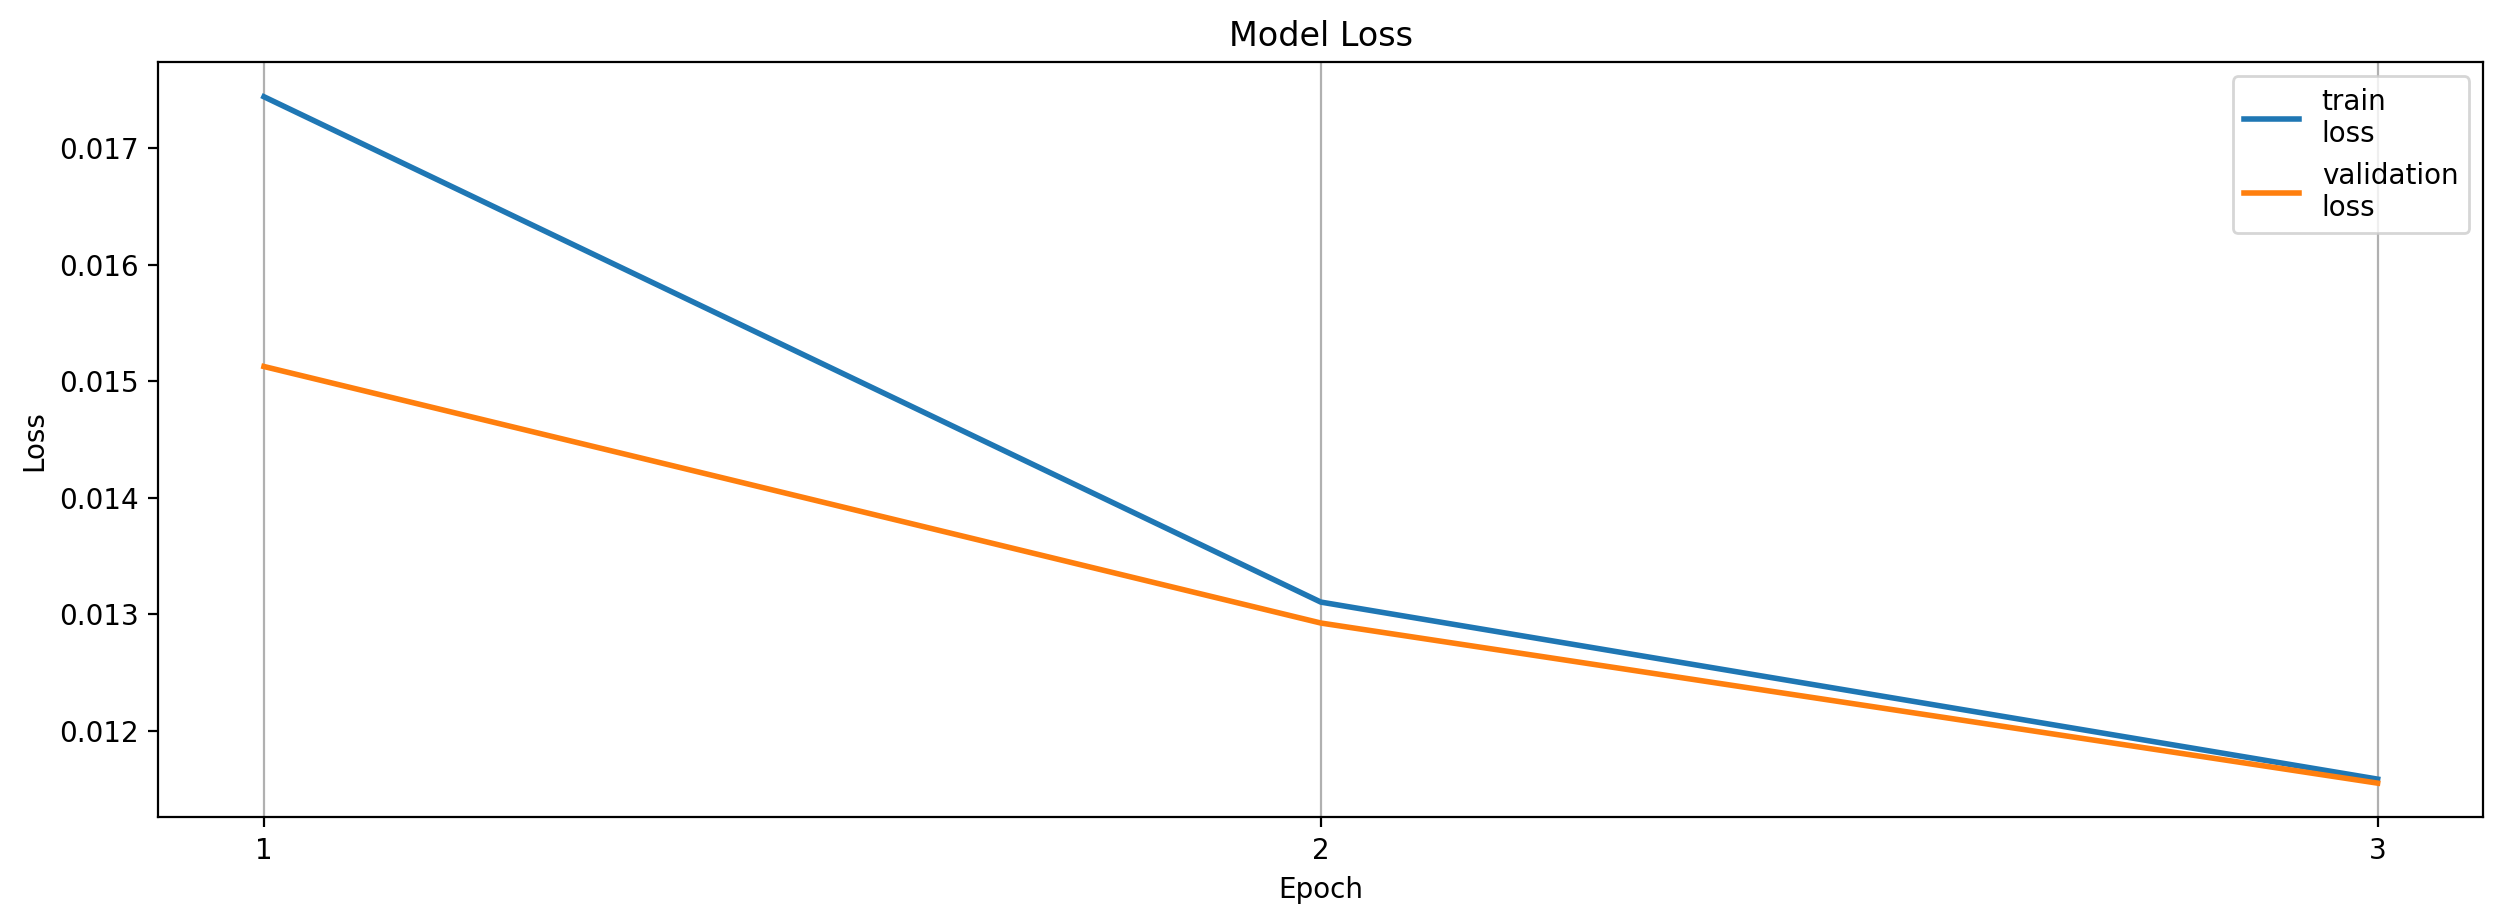

In [21]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot loss
p1 = ax.plot(logger.logger['epochs'], logger.logger['train_loss'], linewidth=2, label='train\nloss')
p2 = ax.plot(logger.logger['epochs'], logger.logger['valid_loss'], linewidth=2, label='validation\nloss')

ax.set_xticks(range(1, EPOCHS + 1))
ax.set_xticklabels(range(1, EPOCHS + 1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss')
ax.xaxis.grid()
ax.legend()

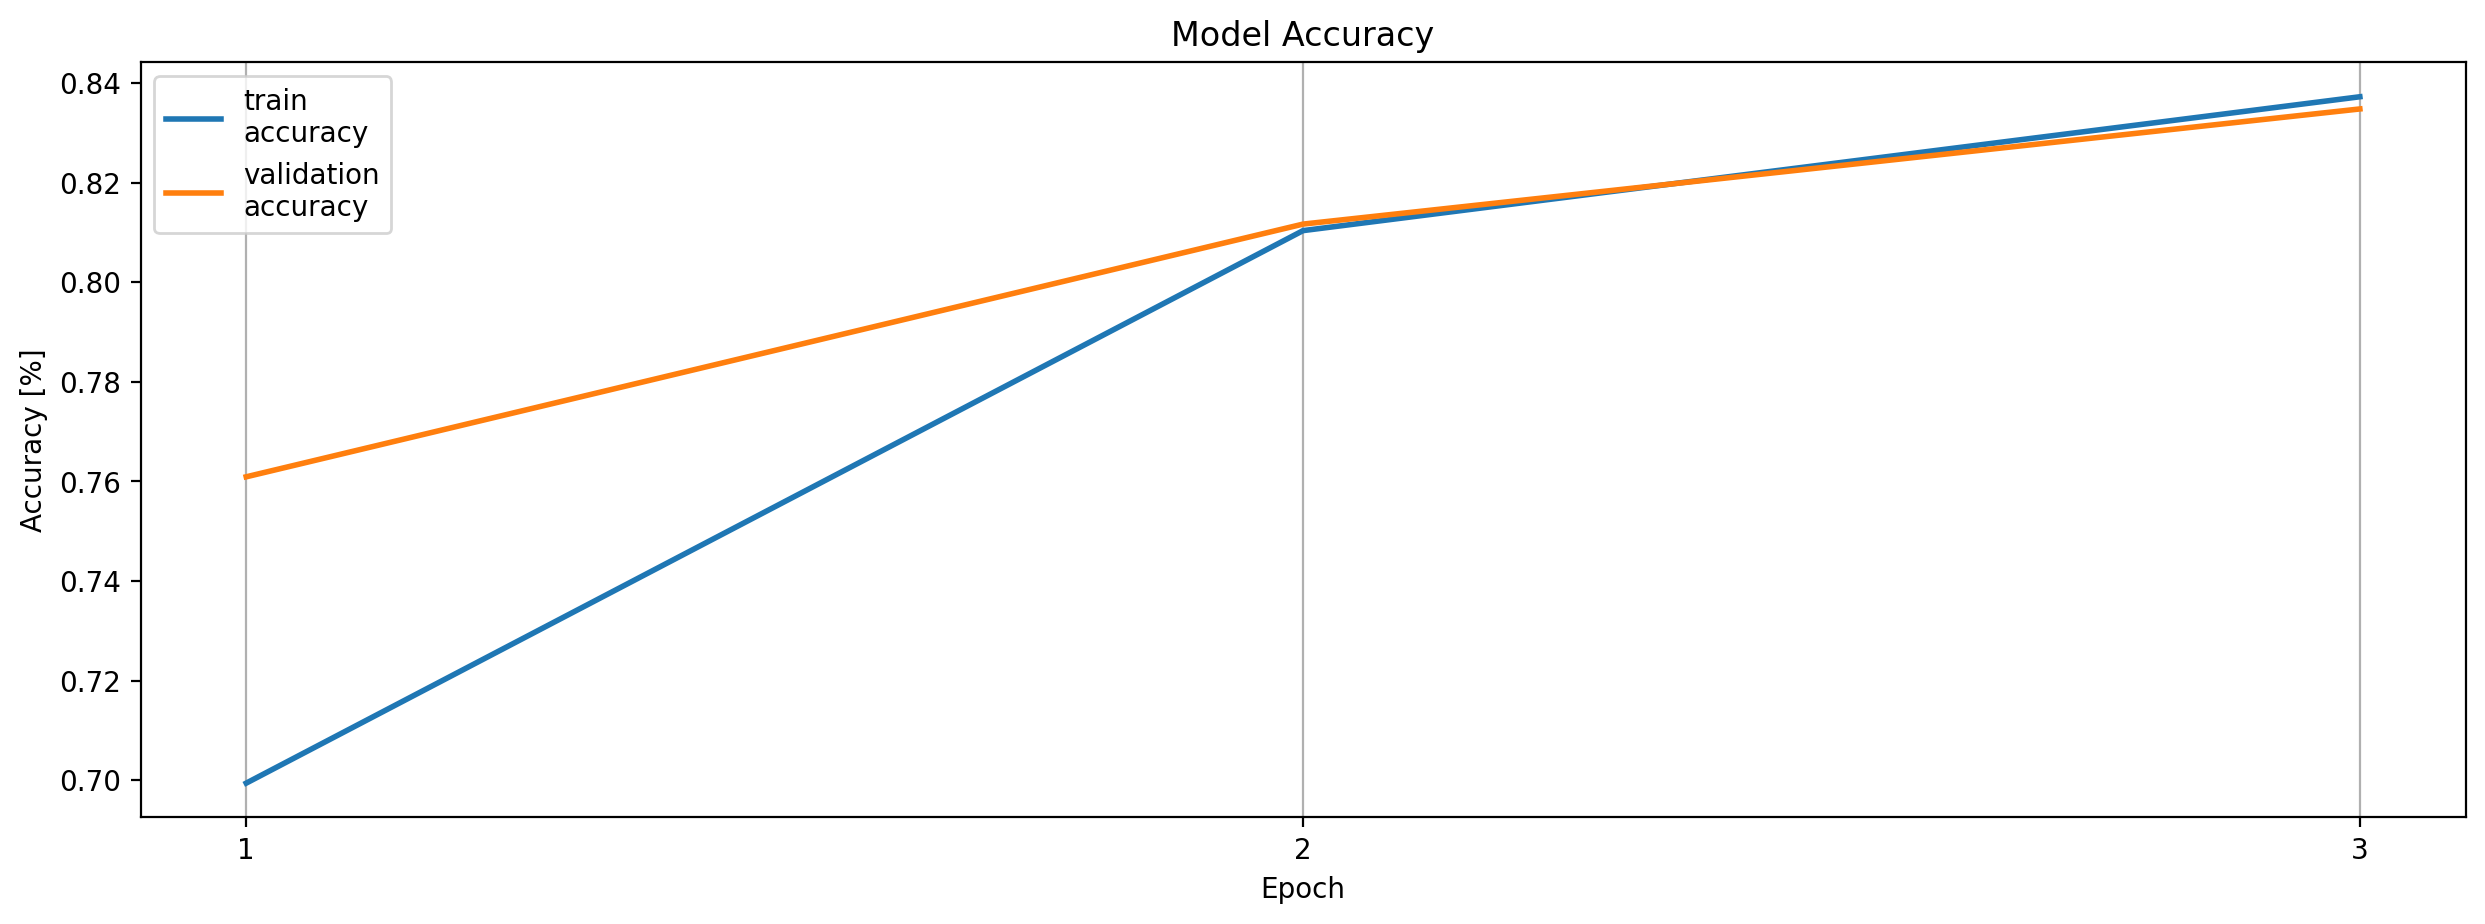

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot accuracy

p7 = ax.plot(logger.logger['epochs'], logger.logger['train_acc'], linewidth=2, label='train\naccuracy')
p8 = ax.plot(logger.logger['epochs'], logger.logger['valid_acc'], linewidth=2, label='validation\naccuracy')

ax.set_xticks(range(1, EPOCHS + 1))
ax.set_xticklabels(range(1, EPOCHS + 1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy [%]')
ax.set_title('Model Accuracy')
ax.xaxis.grid()
ax.legend()

# Predict

In [22]:
test_accs = []
for i, test_dataset in enumerate(test_datasets):
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, collate_fn=collate_batch)
    print(f'Checking the results of TEST dataset with data - {summary_columns[i]}:')
    accu_test = evaluate(test_dataloader)
    test_accs.append(accu_test)
    print('accuracy {:8.3f}'.format(accu_test))

Checking the results of TEST dataset with data - summary-150:
accuracy    0.742
Checking the results of TEST dataset with data - summary-128:
accuracy    0.742
Checking the results of TEST dataset with data - summary-64:
accuracy    0.710
Checking the results of TEST dataset with data - summary-32:
accuracy    0.666
Checking the results of TEST dataset with data - summary-16:
accuracy    0.588
Checking the results of TEST dataset with data - summary-8:
accuracy    0.529
Checking the results of TEST dataset with data - summary-4:
accuracy    0.539


In [ ]:
imdb_label = {0: 'negative',
              1: 'positive'}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_positive_str = "Full of suspense, gripping the entire time, intense, \
  two stories in parallel that come together, somewhat predictable betrayals \
   and twist, felt a bit dark at times, satisfying ending, not a huge amount \
    of action but a solid storyline that keeps you on edge."

ex_negative_str = "This is not your traditional Guy Ritchie movie with slick \
   fast paced action, clever humour and lots of twists. Which I have loved in \
    the past. It is basically a combination of heist movie and revenge \
     thriller. But it's played very straight, without a lot of effort to \
      build characters, and doesn't ever seem to build much momentum. So \
       a few times during the movie I found myself looking at my watch, \
        wondering if it was really going anywhere. The action is fairly \
         tight but mainly gunplay, not much physical action as Statham is \
          famous for. There are no heroes either, Stathams character seems  \
          to be a pretty nasty piece of work himself. All in all, it's an \
           average thriller with nothing in particular to recommend it."

model = model.to("cpu")

print("This is a %s review" %imdb_label[predict(ex_positive_str, text_pipeline)])

This is a positive review
